In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

/Users/eve/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Experiment1
Workload: 
- Weather data,
- SUM(RR/FR), MAX(RR/FR), AVERAGE(RR/FR), SUMIF(RR/FR), MEDIAN(RR/FR)

### Experiment1.1

Baselines: FormS-formulas, FormS

Details: vary the number of cores: 1, 2, 4, 8, 16, 32; 1M rows


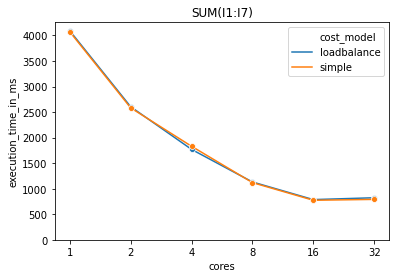

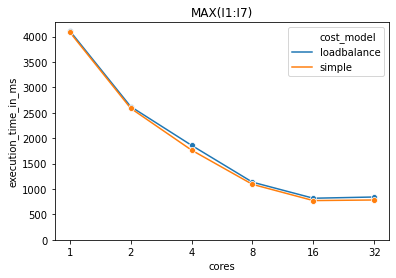

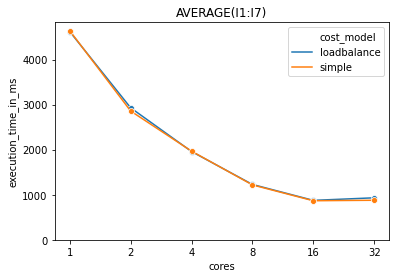

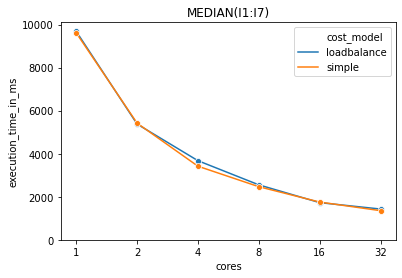

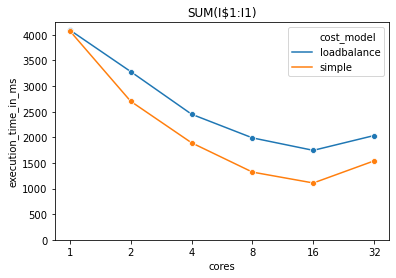

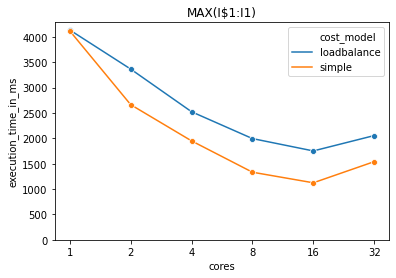

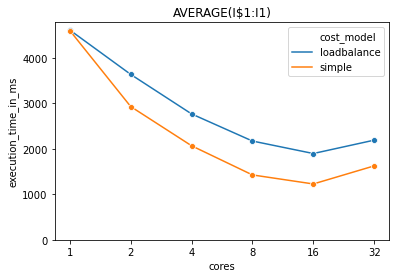

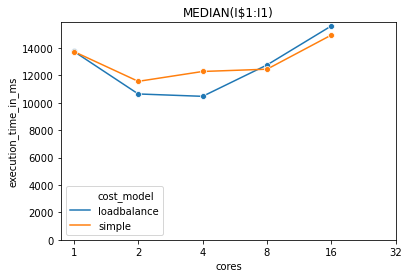

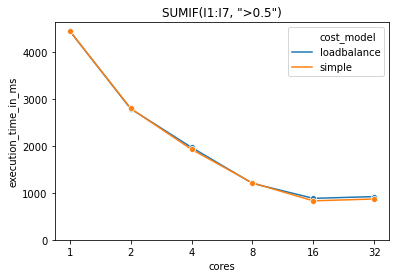

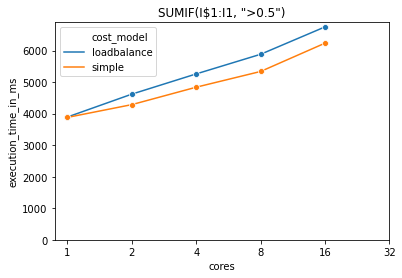

<Figure size 432x288 with 0 Axes>

In [36]:
def change_cores(df):
    df.loc[df['cores'] == 4, "cores"] = 3
    df.loc[df['cores'] == 8, "cores"] = 4
    df.loc[df['cores'] == 16, "cores"] = 5
    df.loc[df['cores'] == 32, "cores"] = 6
    return df

test_path_simple = 'results/TEST-CORES-SIMPLE'
test_path = 'results/TEST-CORES'
for i in range(1, 11):
    path = os.path.join(test_path, str(i))
    all_data = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename == "config.json":
                with open(os.path.join(root, filename), 'r') as f:
                    text = f.read()
                    data = json.loads(text)
                    all_data.append(data)
    path = os.path.join(test_path_simple, str(i))
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename == "config.json":
                with open(os.path.join(root, filename), 'r') as f:
                    text = f.read()
                    data = json.loads(text)
                    all_data.append(data)
    all_df = pd.DataFrame(all_data)
    all_df = all_df[all_df['function_executor'] == 'df_pandas_executor']
    formula_str = all_df.iloc[0]['formula_str'][1:]
    df = all_df[['cores', 'function_executor', 'execution_time_in_ms', 'cost_model']].groupby(['cores', 'function_executor', 'cost_model']).mean().reset_index()
    df = change_cores(df)
    plot = sns.lineplot(data=df, x='cores', y='execution_time_in_ms', hue='cost_model', marker='o')
    plot.set_xticks(range(1,7))
    plot.set_xticklabels([1,2,4,8,16,32])
    plt.ylim(0, None)
    plt.title(formula_str)
    plot.get_figure().savefig('plots/cores-10M-simple/' + formula_str + '.pdf', dpi=300)
    plt.show()
    plt.clf()

### Experiment1.2
Workload and Baseline same as above 

Details: vary the dataset sizes: 200K, 400K, 600K, 800K, 1M rows; 32 cores


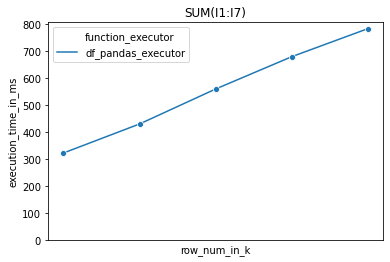

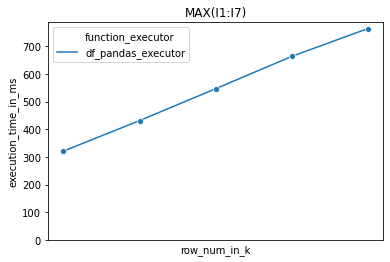

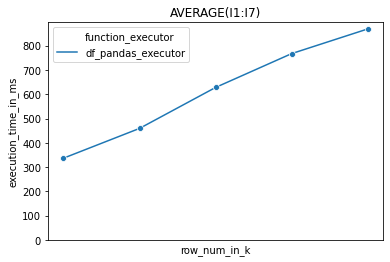

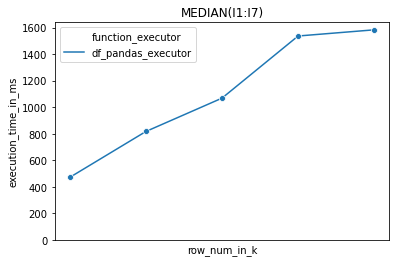

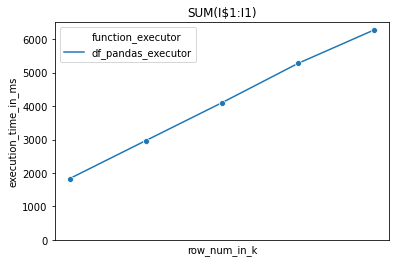

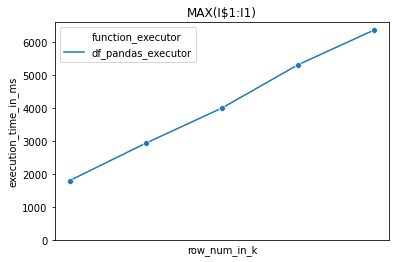

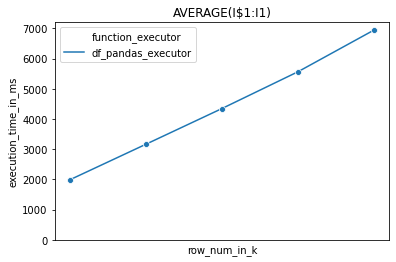

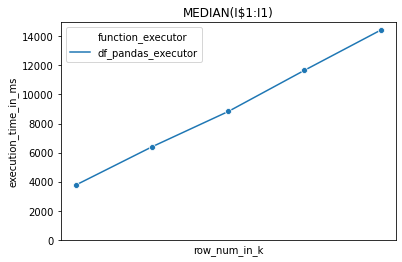

KeyError: 'row_num'

<Figure size 432x288 with 0 Axes>

In [25]:
test_path = 'results/TEST-ROWS'
for i in range(1, 11):
    path = os.path.join(test_path, str(i))
    all_data = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            if filename == "config.json":
                with open(os.path.join(root, filename), 'r') as f:
                    text = f.read()
                    data = json.loads(text)
                    all_data.append(data)
    all_df = pd.DataFrame(all_data)
    all_df['row_num_in_k'] = all_df['row_num'] / 1000
    formula_str = all_df.iloc[0]['formula_str'][1:]
    df = all_df[['row_num_in_k', 'function_executor', 'execution_time_in_ms']].groupby(['row_num_in_k', 'function_executor']).mean().reset_index()
    plot = sns.lineplot(data=df, x='row_num_in_k', y='execution_time_in_ms', hue='function_executor', marker='o')
    plot.xaxis.set_major_locator(FixedLocator([200,400,600,800,1000]))
    plt.title(formula_str)
    plt.ylim(0, None)
    plot.get_figure().savefig('plots/rows/' + formula_str + '.pdf', dpi=300)
    plt.show()
    plt.clf()

## Experiment 2 
Test Rewritten Rules
Workload: Weather data (1M, 32 cores)
Baseline: FormS-norewrite

## Experiment 2.1: 
Rule1-2: A1+B1+C1+..., vary the number of pluses (5 pluses)

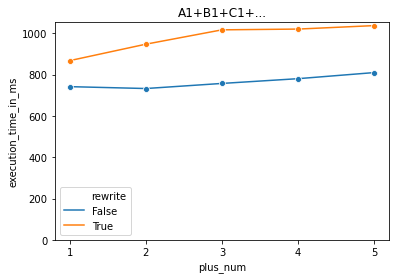

<Figure size 432x288 with 0 Axes>

In [27]:
test_path = 'results/TEST-REWRITE-1'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                data['plus_num'] = int(root[root.find('PLUS') - 1])
                data['rewrite'] = data['enable_logical_rewriting']
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['plus_num', 'rewrite', 'execution_time_in_ms']].groupby(['plus_num', 'rewrite']).mean().reset_index()
plot = sns.lineplot(data=df, x='plus_num', y='execution_time_in_ms', marker='o', hue='rewrite')
plot.xaxis.set_major_locator(FixedLocator([1,2,3,4,5]))
plt.title('A1+B1+C1+...')
plt.ylim(0, None)
plot.get_figure().savefig('plots/rewrite/1.pdf', dpi=300)
plt.show()
plt.clf()

### Experiment 2.2

Rule2: MAX(A1, B$1:B1), the number of rows: 200K, 400K, …, 1M

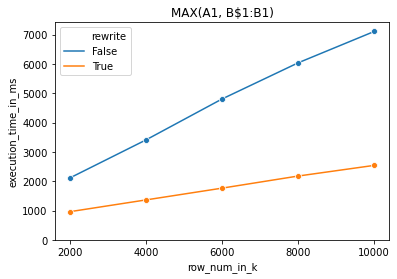

<Figure size 432x288 with 0 Axes>

In [28]:
test_path = 'results/TEST-REWRITE-2'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                data['rewrite'] = data['enable_logical_rewriting']
                all_data.append(data)
all_df = pd.DataFrame(all_data)
all_df['row_num_in_k'] = all_df['row_num'] / 1000
df = all_df[['row_num_in_k', 'rewrite', 'execution_time_in_ms']].groupby(['row_num_in_k', 'rewrite']).mean().reset_index()
plot = sns.lineplot(data=df, x='row_num_in_k', y='execution_time_in_ms', marker='o', hue='rewrite')
plot.xaxis.set_major_locator(FixedLocator([2000,4000,6000,8000,10000]))
plt.title('MAX(A1, B$1:B1)')
plt.ylim(0, None)
plot.get_figure().savefig('plots/rewrite/2.pdf', dpi=300)
plt.show()
plt.clf()

### Experiment 2.3: 

Rule4: SUMIF(): varying the number of overlapping IF conditions across SUMIF functions, SUMIF(A1:A1, “> 10”), SUMIF(A1:A5, “> 10”), SUMIF(A1:A10, “> 10”), …


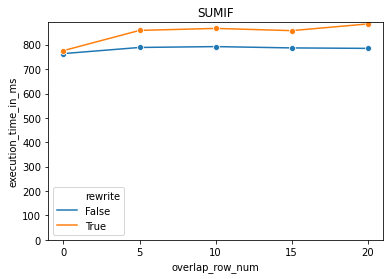

<Figure size 432x288 with 0 Axes>

In [31]:
test_path = 'results/TEST-REWRITE-3'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                root = root[:root.find('OVERLAP')]
                root = root[root.rfind('/')+1:]
                data['overlap_row_num'] = int(root)
                data['rewrite'] = data['enable_logical_rewriting']
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['overlap_row_num', 'rewrite', 'execution_time_in_ms']].groupby(['overlap_row_num', 'rewrite']).mean().reset_index()
plot = sns.lineplot(data=df, x='overlap_row_num', y='execution_time_in_ms', marker='o', hue='rewrite')
plot.xaxis.set_major_locator(FixedLocator([0,5,10,15,20]))
plt.title('SUMIF')
plt.ylim(0, None)
plot.get_figure().savefig('plots/rewrite/3.pdf', dpi=300)
plt.show()
plt.clf()

### Experiment 2.4: 
Rule6: SUM(A1, A\\$1:A\\$200K): vary the size of the FF ranges: A1:A200000, A1:A400000, A1:A600000, …, A1:A1000000 -->

In [32]:
test_path = 'results/TEST-REWRITE-4'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                root = root[:root.find('kRANGE')]
                root = root[root.rfind('/')+1:]
                data['range_row_num_in_k'] = int(root)
                data['rewrite'] = data['enable_logical_rewriting']
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['range_row_num_in_k', 'rewrite', 'execution_time_in_ms']].groupby(['range_row_num_in_k', 'rewrite']).mean().reset_index()
plot = sns.lineplot(data=df, x='range_row_num_in_k', y='execution_time_in_ms', marker='o', hue='rewrite')
plot.xaxis.set_major_locator(FixedLocator([2000,4000,6000,8000,10000]))
plt.title('SUM')
plt.ylim(0, None)
plot.get_figure().savefig('plots/rewrite/4.pdf', dpi=300)
plt.show()
plt.clf()

ValueError: invalid literal for int() with base 10: 'TEST-REWRITE-'

## Experiment 3

Workload: Weather data from RQ1

Experiment 3.1: RR, Different directions for computing distributive aggregate functions, varying the number of columns in the range SUM(A1:A7), SUM(A1:B7), …, SUM(A1:E7)


In [ ]:
test_path = 'results/TEST-DIRECTION'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                data['col_num'] = int(root[root.find('DIRECTION')+2])
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['col_num', 'along_row_first', 'execution_time_in_ms']].groupby(['col_num', 'along_row_first']).mean().reset_index()
plot = sns.lineplot(data=df, x='col_num', y='execution_time_in_ms', marker='o', hue='along_row_first')
plot.xaxis.set_major_locator(FixedLocator([1,2,3,4,5]))
plt.title('Compare Different Directions')
plt.ylim(0, None)
plot.get_figure().savefig('plots/directions/1.pdf', dpi=300)
plt.clf()

## Experiment 4 

Workload: Weather data (1M, 32 cores)

### Experiment 4.1: 

MEDIAN(A1:B\\$1), vary the number of rows, report the execution time


In [12]:
test_path = 'results/TEST-COSTMODEL'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                data['row_num_in_k'] = data['row_num'] / 1000
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['row_num_in_k', 'cost_model', 'execution_time_in_ms']].groupby(['row_num_in_k', 'cost_model']).mean().reset_index()
plot = sns.lineplot(data=df, x='row_num_in_k', y='execution_time_in_ms', marker='o', hue='cost_model')
plot.xaxis.set_major_locator(FixedLocator([2000,4000,6000,8000,10000]))
plt.title('Compare Different Directions')
plt.ylim(0, None)
plot.get_figure().savefig('plots/directions/execution_time.pdf', dpi=300)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Experiment 4.2: 

MEDIAN(A1:B\\$1), vary the number of rows, report the planning time

In [ ]:
test_path = 'results/TEST-COSTMODEL'
all_data = []
for root, dirs, files in os.walk(test_path):
    for filename in files:
        if filename == "config.json":
            with open(os.path.join(root, filename), 'r') as f:
                text = f.read()
                data = json.loads(text)
                data['row_num_in_k'] = data['row_num'] / 1000
                all_data.append(data)
all_df = pd.DataFrame(all_data)
df = all_df[['row_num_in_k', 'cost_model', 'planning_time_in_ms']].groupby(['row_num_in_k', 'cost_model']).mean().reset_index()
plot = sns.lineplot(data=df, x='row_num_in_k', y='planning_time_in_ms', marker='o', hue='cost_model')
plot.xaxis.set_major_locator(FixedLocator([200,400,600,800,1000]))
plt.title('Compare Different Cost Model')
plt.ylim(0, None)
plot.get_figure().savefig('plots/costmodel/planning_time.pdf', dpi=300)
plt.clf()

## Experiment 5

Workload: Weather data,
  SUM(RR, FR), MAX(RR, FR), AVERAGE(RR, FR), SUMIF(RR, FR), MEDIAN(RR, FR)
  
  
Baselines: FormS and Excel

Experiment 5.1: vary the number of cores: 1, 2, 4, 8, 16; 10K rows
